In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pyproj import Transformer
from pyproj import CRS
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 14})

In [2]:
def remove_outliers_IQR(data, limit):
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    outliers = data[np.isnan(data_cp)]
    
    print('Removed %d / %d points (%.1f percent)' % (len(outliers[~np.isnan(outliers)]), len(data), (len(outliers[~np.isnan(outliers)])/len(data))*100))
    return data_cp

In [3]:
### load the SSH data for paired buoys

buoy_ssh = xr.open_mfdataset('co-deployed_GNSS_buoys.nc')

In [4]:
### calculate the difference for each pair

diff_1 = buoy_ssh.pair_1_ssh_a.values - buoy_ssh.pair_1_ssh_b.values
diff_2 = buoy_ssh.pair_2_ssh_a.values - buoy_ssh.pair_2_ssh_b.values
diff_3 = buoy_ssh.pair_3_ssh_a.values - buoy_ssh.pair_3_ssh_b.values
diff_4 = buoy_ssh.pair_4_ssh_a.values - buoy_ssh.pair_4_ssh_b.values
diff_5 = buoy_ssh.pair_5_ssh_a.values - buoy_ssh.pair_5_ssh_b.values
diff_6 = buoy_ssh.pair_6_ssh_a.values - buoy_ssh.pair_6_ssh_b.values
diff_7 = buoy_ssh.pair_7_ssh_a.values - buoy_ssh.pair_7_ssh_b.values


In [5]:
### remove gross outliers using IQR * 3

diff_1_clean = remove_outliers_IQR(diff_1, 3)
diff_2_clean = remove_outliers_IQR(diff_2, 3)
diff_3_clean = remove_outliers_IQR(diff_3, 3)
diff_4_clean = remove_outliers_IQR(diff_4, 3)
diff_5_clean = remove_outliers_IQR(diff_5, 3)
diff_6_clean = remove_outliers_IQR(diff_6, 3)
diff_7_clean = remove_outliers_IQR(diff_7, 3)


Removed 504 / 23974 points (2.1 percent)
Removed 52 / 12015 points (0.4 percent)
Removed 115 / 7060 points (1.6 percent)
Removed 27 / 2745 points (1.0 percent)
Removed 25 / 7030 points (0.4 percent)
Removed 26 / 5695 points (0.5 percent)
Removed 564 / 43230 points (1.3 percent)


In [6]:
# print mean differences for each

print(np.nanmean(diff_1_clean)*1000)
print(np.nanmean(diff_2_clean)*1000)
print(np.nanmean(diff_3_clean)*1000)
print(np.nanmean(diff_4_clean)*1000)
print(np.nanmean(diff_5_clean)*1000)
print(np.nanmean(diff_6_clean)*1000)
print(np.nanmean(diff_7_clean)*1000)

0.8174896327432064
-1.469634855781249
3.4795068434338416
-21.820673744288854
-0.28344511933888866
0.8674121923033065
-1.0845269793936052


In [7]:
# print mean standard deviations for each

print(np.nanstd(diff_1_clean)*1000)
print(np.nanstd(diff_2_clean)*1000)
print(np.nanstd(diff_3_clean)*1000)
print(np.nanstd(diff_4_clean)*1000)
print(np.nanstd(diff_5_clean)*1000)
print(np.nanstd(diff_6_clean)*1000)
print(np.nanstd(diff_7_clean)*1000)

6.040473048361269
5.789532254964156
6.2605195280904375
5.423354956784825
5.951301509533403
7.475728573689094
6.767584666814789


In [8]:
### combine all diffs

all_diffs_clean = np.concatenate([diff_1_clean, 
            diff_2_clean, 
            diff_3_clean, 
            diff_4_clean, 
            diff_5_clean, 
            diff_6_clean, 
            diff_7_clean])

all_diffs = np.concatenate([diff_1, 
            diff_2, 
            diff_3, 
            diff_4, 
            diff_5, 
            diff_6, 
            diff_7])

a = len(all_diffs_clean.flatten()[~np.isnan(all_diffs_clean.flatten())])
b = len(all_diffs.flatten()[~np.isnan(all_diffs.flatten())])

print('Percentage of outliers removed: %.1f' %((1 - a/b)*100))

Percentage of outliers removed: 1.7


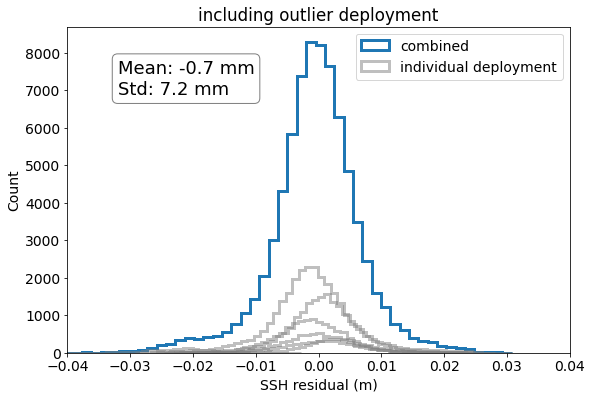

In [9]:
### plot histogram of results

# Calculate the std and mean for the combined data
std_all = np.nanstd(all_diffs_clean)*1000
mean_all = np.nanmean(all_diffs_clean)*1000

fig, ax = plt.subplots(1, figsize=(9,6))
ax.hist(all_diffs_clean, 50, histtype='step', lw=3, label='combined')
ax.hist(diff_1_clean, 50, alpha=0.5, histtype='step', lw=3, label='individual deployment', color='grey')
ax.hist(diff_2_clean, 50, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_3_clean, 50, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_4_clean, 50, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_5_clean, 50, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_6_clean, 50, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_7_clean, 50, alpha=0.5, histtype='step', lw=3, color='grey')
plt.legend()
ax.set_title('including outlier deployment')
ax.set_ylabel('Count')
ax.set_xlabel('SSH residual (m)')

# Add a text box with the std and mean values
textstr = f'Mean: {mean_all:.1f} mm\nStd: {std_all:.1f} mm'
props = dict(boxstyle='round', facecolor='w', alpha=0.5)
ax.text(0.1, 0.9, textstr, transform=ax.transAxes, fontsize=18, verticalalignment='top', bbox=props)

ax.set_xlim(-0.04, 0.04)

plt.show()


In [10]:
### remove outlier deployement and recalculate

all_diffs_clean = np.concatenate([diff_1_clean, 
                                  diff_2_clean, 
                                  diff_3_clean, 
                                  diff_5_clean, 
                                  diff_6_clean, 
                                  diff_7_clean])

a = len(all_diffs_clean.flatten()[~np.isnan(all_diffs_clean.flatten())])
b = len(all_diffs.flatten()[~np.isnan(all_diffs.flatten())])

print('Percentage of outliers removed: %.1f' %((1 - a/b)*100))

Percentage of outliers removed: 3.8


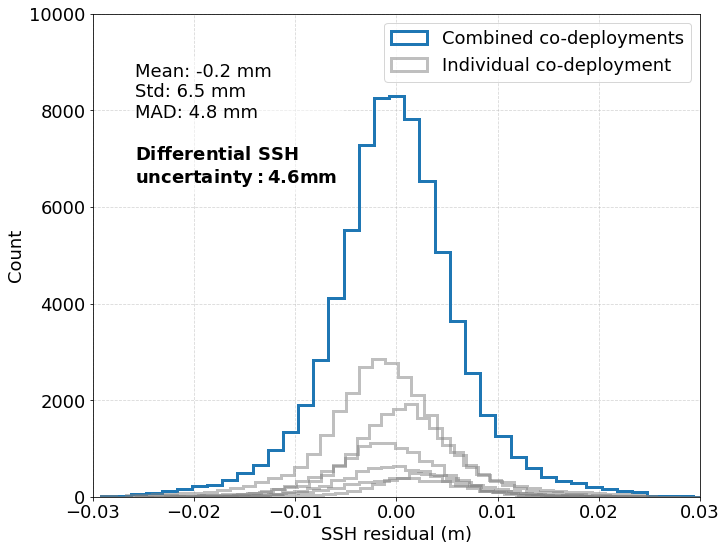

In [11]:
cm = 1/2.54  # centimeters in inches
fig_width = 17.4 #*cm
plt.rcParams.update({'font.size': 18})

# Calculate the std and mean for the combined data
std_all = np.nanstd(all_diffs_clean)*1000
mean_all = np.nanmean(all_diffs_clean)*1000
buoy_meas_uncertainty = np.nanstd(all_diffs_clean*1000)/np.sqrt(2)
MAD = np.nanmean(abs(all_diffs_clean*1000))

fig, ax = plt.subplots(1, figsize=(fig_width*0.6, 8), sharex=True)

ax.hist(all_diffs_clean, 40, histtype='step', lw=3, color='C0', label='Combined co-deployments')
ax.hist(diff_1_clean, 40, alpha=0.5, histtype='step', lw=3, label='Individual co-deployment', color='grey')
ax.hist(diff_2_clean, 40, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_3_clean, 40, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_5_clean, 40, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_6_clean, 40, alpha=0.5, histtype='step', lw=3, color='grey')
ax.hist(diff_7_clean, 40, alpha=0.5, histtype='step', lw=3, color='grey')
ax.legend()
ax.set_ylabel('Count')
ax.set_xlabel('SSH residual (m)')

# Add a text box with the std and mean values
textstr = f"Mean: {mean_all:.1f} mm\nStd: {std_all:.1f} mm\nMAD: {MAD:.1f} mm\n\n$\mathbf{{Differential~SSH}}$\n$\mathbf{{uncertainty: {buoy_meas_uncertainty:.1f} mm}}$"

props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.5)
ax.text(0.07, 0.9, textstr, transform=ax.transAxes, fontsize=18, verticalalignment='top', bbox=props)
ax.grid(ls = '--', alpha=0.5) 
ax.set_xlim(-0.03, 0.03)
ax.set_ylim(0,10000)

plt.tight_layout()
plt.show()